In [528]:
import numpy as np  
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import make_blobs, make_moons, load_iris, load_digits

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, Birch, MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.metrics.cluster import adjusted_rand_score, v_measure_score
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage
from sklearn.decomposition import PCA
from kneed import KneeLocator
from sklearn.neighbors import NearestNeighbors

import time
from joblib import cpu_count

# Porównanie i ocena algorytmów grupowania 

## Przykład 1: miary ARI, V-measure i współczynnik sylwetki dla danych `two moons`

Dla danych `two moons` porównaj grupowanie k-średnich, aglomeracyjne i DBSCAN przy użyciu ARI, V-measure i współczynnika sylwetki. 
Porównaj wyniki także z losowym przypisaniem punktów do dwóch klastrów. Zwizualizuj wyniki.

In [374]:
X, y = make_moons(n_samples=200, noise =.05, random_state=7)

In [375]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

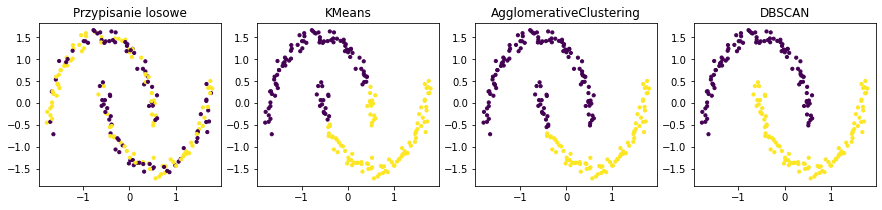

,Przypisanie losowe,KMeans,AgglomerativeClustering,DBSCAN
ARI,-0.0,0.47,0.65,1.00
V-measure,0.0,0.38,0.63,1.00
silhouette_score,0.0,0.49,0.45,0.38


In [376]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))

algorithms = [KMeans(n_clusters=2, n_init=10),
             AgglomerativeClustering(n_clusters=2),
             DBSCAN()]

# losowe przypisanie punktów do klastrów
random_state = np.random.RandomState(seed=7)
random_clusters = random_state.randint(low=0, high=2, size=len(X))  # losowanie ze zbioru [0, 1]

axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=random_clusters, s=10)
axes[0].set_title("Przypisanie losowe")

indeksy = pd.DataFrame(columns=["Przypisanie losowe", "KMeans", "AgglomerativeClustering", "DBSCAN"],
                       index = ["ARI", "V-measure", "silhouette_score"])

indeksy["Przypisanie losowe"] = [adjusted_rand_score(y, random_clusters),
                                 v_measure_score(y, random_clusters),
                                 silhouette_score(X_scaled, random_clusters)]

for ax, algorithm in zip(axes[1:], algorithms):
    
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, s=10)
    alg_str = str(algorithm).split("(")[0]  # dzielenie pełnej nazwy algorytmu (nazwa przed pierwszym nawiasem)
    ax.set_title(alg_str)
    
    indeksy[alg_str] = [adjusted_rand_score(y, clusters),
                        v_measure_score(y, clusters),
                        silhouette_score(X_scaled, clusters)]
    
plt.show()

round(indeksy, 2)

In [377]:
pd.crosstab(clusters, y)  # dla ostatniego algorytmu (DBSCAN)

col_0,0,1
row_0,,
0,100,0
1,0,100


In [378]:
pd.crosstab(random_clusters, y)  # dla przypisania losowego

col_0,0,1
row_0,,
0,44,50
1,56,50


## Ćwiczenie 1: miary ARI i V-measure dla danych `Irysy`

Dla danych `Irysy` porównaj grupowania znalezione przez algorytmy grupowania k-średnich i aglomeracyjne
za pomocą indeksu ARI i V-measure. Zwizualiuj wyniki.

In [19]:
iris = load_iris()
y = iris.target

In [28]:
np.bincount(y)

array([50, 50, 50])

In [29]:
X_scaled = StandardScaler().fit_transform(iris.data)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

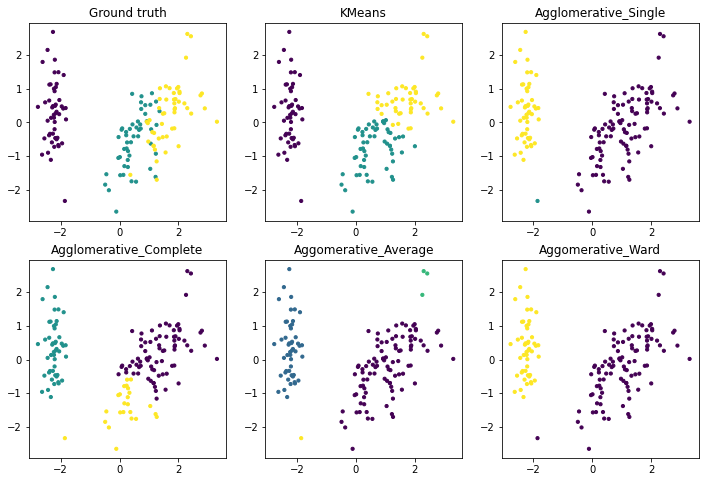

,KMeans,Agglomerative_Single,Agglomerative_Complete,Aggomerative_Average,Aggomerative_Ward
ARI,0.59,0.56,0.57,0.55,0.54
V-measure,0.64,0.72,0.65,0.70,0.69


In [58]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

algorithms = [KMeans(n_clusters=3, n_init=10, random_state=7),
              AgglomerativeClustering(n_clusters=3, linkage="single"),
              AgglomerativeClustering(n_clusters=3, linkage="complete"),
              AgglomerativeClustering(n_clusters=4, linkage="average"),
              AgglomerativeClustering(n_clusters=2, linkage="ward")]

titles = ["KMeans", "Agglomerative_Single", "Agglomerative_Complete", "Aggomerative_Average", "Aggomerative_Ward"]

indeksy = pd.DataFrame(index = ["ARI", "V-measure"])

axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=10)
axes[0].set_title("Ground truth")

for ax, algorithm, title in zip(axes[1:], algorithms, titles):
    
    clusters = algorithm.fit_predict(X_scaled)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, s=10)
    ax.set_title(title)
    
    indeksy[title] = [adjusted_rand_score(y, clusters), v_measure_score(y, clusters)]
    
plt.show()

round(indeksy, 2)

# Grupowanie danych mieszanych

## Przykład 2: grupowanie danych mieszanych blobs za pomocą kodowania binarnego zmiennych kategorialnych

Dla danych `blobs` zakoduj zmienną kategorialną za pomocą zmiennych binarnych i zgrupuj dane za pomocą 
klateryzacji k-średnich z liczbą klastrów `k=3`. Policz ARI i porównaj wynik klasteryzacji do klasteryzacji 
k-średnich tylko na zmiennych ciągłych.  

In [334]:
X, y = make_blobs(n_samples=100, centers=3, n_features=3, center_box=[-6, 6], random_state=1234)

X = pd.DataFrame(X, columns=['X1', 'X2', 'X3'])
X['X3'] = np.where(X['X3'] < -2, 'LOW', np.where(X['X3'] > 2, 'HIGH', 'MEDIUM'))

In [335]:
X.head()

,X1,X2,X3
0,-3.890860,0.092066,MEDIUM
1,-2.311276,4.550265,HIGH
2,-4.032373,2.339433,MEDIUM
3,4.668072,4.093457,LOW
4,-2.588132,1.091546,HIGH


In [336]:
con = ["X1", "X2"]  # zmienne ilościowe
cat = "X3"  # zmienne jakościowe

In [337]:
X["X3"].value_counts()

X3
MEDIUM    41
HIGH      33
LOW       26
Name: count, dtype: int64

In [341]:
X_dum = pd.get_dummies(X, drop_first=True, dtype=int)
X_dum.head()

,X1,X2,X3_LOW,X3_MEDIUM
0,-3.890860,0.092066,0,1
1,-2.311276,4.550265,0,0
2,-4.032373,2.339433,0,1
3,4.668072,4.093457,1,0
4,-2.588132,1.091546,0,0


In [342]:
scaler = StandardScaler()

X_dum[:] = scaler.fit_transform(X_dum)
X_dum.head()

,X1,X2,X3_LOW,X3_MEDIUM
0,-0.953471,-2.206143,-0.592749,1.199593
1,-0.450817,1.346499,-0.592749,-0.833616
2,-0.998503,-0.415265,-0.592749,1.199593
3,1.770144,0.982478,1.687055,-0.833616
4,-0.538918,-1.409679,-0.592749,-0.833616


In [84]:
model = KMeans(n_clusters=3, n_init=10, random_state=7)

model.fit(X_dum)
labels = model.labels_

In [85]:
adjusted_rand_score(labels, y)

0.719614257190195

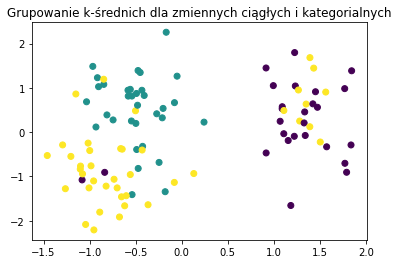

In [100]:
plt.scatter(X_dum["X1"], X_dum["X2"], c=labels)  # można wykonać PCA lub dodać kształty punktów jako "X3"
plt.title("Grupowanie k-średnich dla zmiennych ciągłych i kategorialnych")
plt.show()

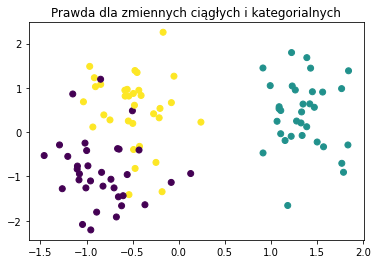

In [91]:
plt.scatter(X_dum["X1"], X_dum["X2"], c=y)
plt.title("Wartości prawdziwe etykiet")
plt.show()

In [95]:
model2 = KMeans(n_clusters=3, n_init=10, random_state=7)

model2.fit(X_dum[con])
labels2 = model2.labels_

In [96]:
adjusted_rand_score(labels2, y)  # zatem dodanie zmiennej jakościowej POGARSZA jakość klasteryzacji

0.7293278537362832

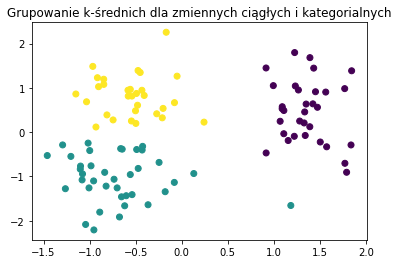

In [97]:
plt.scatter(X_dum["X1"], X_dum["X2"], c=labels2)
plt.title("Grupowanie k-średnich tylko dla zmiennych ciągłych")
plt.show()

## Ćwiczenie 2: grupowanie danych mieszanych heart za pomocą kodowania binarnego zmiennych kategorialnych

**Zbiór danych _Cleveland Heart Disease_ pochodzi z repozytorium _UCI machine learning_: https://archive.ics.uci.edu/ml/datasets/heart+disease**

Zawiera 13 zmiennych, z czego 5 numerycznych i 8 kategorialnych. Liczba pacjentów jest równa 303, zmienną objaśnianą jest binarna zmienna mówiąca o obecności choroby serca. Kolumna target będzie nam służyła do oceny jakości grupowań.

Dla danych `heart` zakoduj zmienne kategorialne za pomocą zmiennych binarnych i zgrupuj dane za pomocą 
klateryzacji k-średnich z liczbą klastrów `k=2`. Policz ARI i porównaj wynik klasteryzacji do klasteryzacji 
k-średnich tylko na zmiennych ciągłych. Zaprezentuj wyniki lepszej metody na wykresie.

In [510]:
heart = pd.read_csv("./heart.csv")

In [511]:
heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [516]:
np.sum(heart.isna())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

### Przygotowanie danych (inżynieria cech)

In [517]:
X, y = heart.drop(['target'], axis=1), heart.target

X.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000


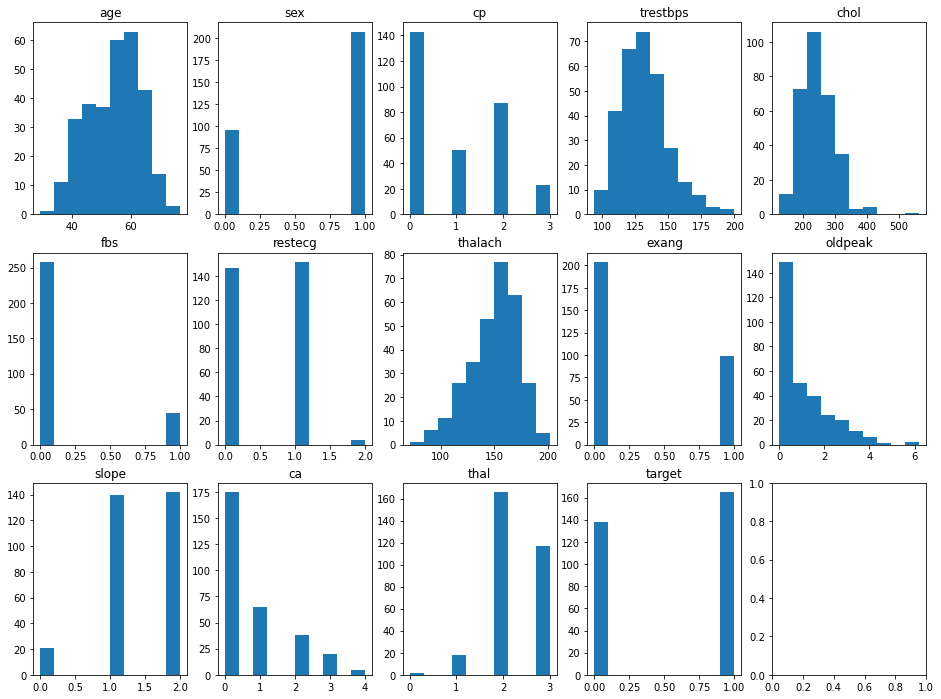

In [518]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(16, 12))
ax = axes.ravel()

for i, col in enumerate(heart.columns):
    
    ax[i].hist(heart[col])
    ax[i].set_title(str(col))
    
plt.show()

In [519]:
con = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']  # zmienne ilościowe
cat = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']  # zmienne jakościowe

In [520]:
X[cat] = X[cat].astype('category')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    int64   
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trestbps  303 non-null    int64   
 4   chol      303 non-null    int64   
 5   fbs       303 non-null    category
 6   restecg   303 non-null    category
 7   thalach   303 non-null    int64   
 8   exang     303 non-null    category
 9   oldpeak   303 non-null    float64 
 10  slope     303 non-null    category
 11  ca        303 non-null    category
 12  thal      303 non-null    category
dtypes: category(8), float64(1), int64(4)
memory usage: 15.6 KB


In [521]:
X_dum = pd.get_dummies(X, drop_first=True)
X_dum[:] = StandardScaler().fit_transform(X_dum)

X_dum.head()

,age,trestbps,chol,thalach,oldpeak,sex_1,cp_1,cp_2,cp_3,fbs_1,...,exang_1,slope_1,slope_2,ca_1,ca_2,ca_3,ca_4,thal_1,thal_2,thal_3
0,0.952197,0.763956,-0.256334,0.015443,1.087338,0.681005,-0.444554,-0.634648,3.489114,2.394438,...,-0.696631,-0.926766,-0.939142,-0.522599,-0.378677,-0.265841,-0.129532,3.979112,-1.100763,-0.793116
1,-1.915313,-0.092738,0.072199,1.633471,2.122573,0.681005,-0.444554,1.575677,-0.286606,-0.417635,...,-0.696631,-0.926766,-0.939142,-0.522599,-0.378677,-0.265841,-0.129532,-0.251312,0.908461,-0.793116
2,-1.474158,-0.092738,-0.816773,0.977514,0.310912,-1.468418,2.249444,-0.634648,-0.286606,-0.417635,...,-0.696631,-0.926766,1.064802,-0.522599,-0.378677,-0.265841,-0.129532,-0.251312,0.908461,-0.793116
3,0.180175,-0.663867,-0.198357,1.239897,-0.206705,0.681005,2.249444,-0.634648,-0.286606,-0.417635,...,-0.696631,-0.926766,1.064802,-0.522599,-0.378677,-0.265841,-0.129532,-0.251312,0.908461,-0.793116
4,0.290464,-0.663867,2.082050,0.583939,-0.379244,-1.468418,-0.444554,-0.634648,-0.286606,-0.417635,...,1.435481,-0.926766,1.064802,-0.522599,-0.378677,-0.265841,-0.129532,-0.251312,0.908461,-0.793116


### pełny model dla wszystkich zmiennych

In [531]:
model1 = KMeans(n_clusters=2, n_init=10, random_state=7)
model1.fit(X_dum)

print(f"ARI: {round(adjusted_rand_score(model1.labels_, y), 2)}")
print(f"V-measure: {round(v_measure_score(model1.labels_, y), 2)}")
print(f"accuracy: {round(accuracy_score(model1.labels_, y), 2)}")

pd.crosstab(model1.labels_, y)

ARI: 0.34
V-measure: 0.26
accuracy: 0.79


target,0,1
row_0,,
0,109,34
1,29,131


### model tylko dla zmiennych ciągłych

In [532]:
# WNIOSEK: dodanie zmiennych jakościowej POPRAWIA jakość klasteryzacji

model2 = KMeans(n_clusters=2, n_init=10, random_state=7)
model2.fit(X_dum[con])

print(f"ARI: {round(adjusted_rand_score(model2.labels_, y), 2)}")
print(f"V-measure: {round(v_measure_score(model2.labels_, y), 2)}")
print(f"accuracy: {round(accuracy_score(model2.labels_, y), 2)}")

pd.crosstab(model2.labels_, y)

ARI: 0.16
V-measure: 0.12
accuracy: 0.7


target,0,1
row_0,,
0,90,42
1,48,123


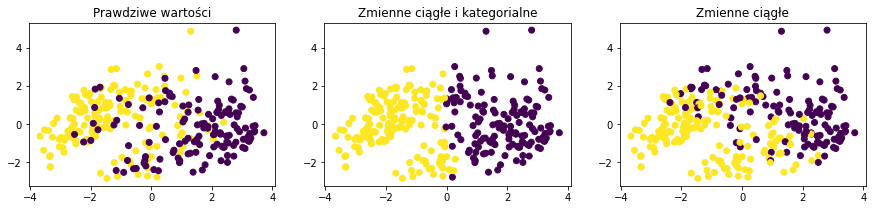

In [527]:
fig, axes = plt.subplots(1, 3, figsize=(15, 3))

titles = ["Prawdziwe wartości",
          "Zmienne ciągłe i kategorialne", 
          "Zmienne ciągłe"]

labels = [y, model1.labels_, model2.labels_]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dum)

for ax, title, label in zip(axes, titles, labels):
    
    ax.scatter(X_pca[:,0], X_pca[:,1], c=label)
    ax.set_title(title)

plt.show()

# Grupowanie dużych danych

## Przykład 3: działanie algorytmu BIRCH i grupowania k-średnich na danych `blobs`

Dla danych `blobs` zastosuj w pierwszym kroku algorytm BIRCH, a następnie klasteryzację 
k-średnich. Porównaj wyniki z klasteryzacją k-średnich bez wstępnego grupowania za pomocą BIRCH
oraz z grupowaniem BIRCH z zadaną liczbą klastrów. Sprawdź co się stanie jak w pierwszym kroku BIRCH wybierzesz `threshold = 5`.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.Birch.html

In [107]:
X = make_blobs(n_samples=2000, centers=7, random_state=7)[0]

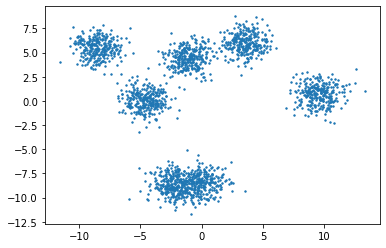

In [115]:
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.show()

### Model 1 (wyliczamy optymalną liczbę klastrów)

In [111]:
model_birch = Birch(n_clusters=None)  # drugi krok klastrowania nie jest wykonywany, zrobimy to ręcznie

model_birch.fit(X)  # UWAGA: świadomie nie skalujemy danych!

centers_birch = model_birch.subcluster_centers_
labels_birch = model_birch.labels_

In [113]:
centers_birch.shape

(161, 2)

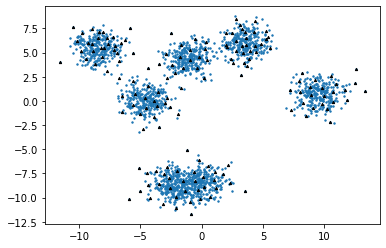

In [116]:
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.scatter(centers_birch[:, 0], centers_birch[:, 1], c="black", marker="^", s=5)

plt.show()

In [119]:
labels_birch.shape, labels_birch

((2000,), array([ 35, 160,  37, ...,  63,  31,  20]))

In [120]:
Xsmall = centers_birch

wss = []
sil_score = []

for i in range(1, 15):
    
    model = KMeans(n_clusters=i, n_init=10, random_state=7)
    model.fit(Xsmall)
    
    wss.append(model.inertia_)  # WSS
    
    if i > 1:
        sil_score.append(silhouette_score(Xsmall, model.labels_))  # silhouette

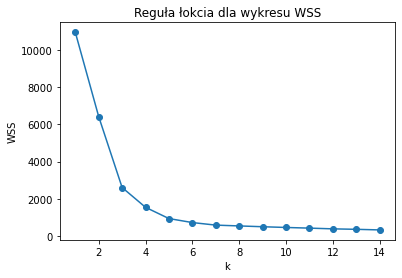

In [122]:
plt.plot(range(1, 15), wss, "-o")

plt.title("Reguła łokcia dla wykresu WSS")
plt.xlabel("k")
plt.ylabel("WSS")
plt.show()

In [125]:
# automatyczne wyznaczanie punktu przegięcia

kl = KneeLocator(range(1, 15), wss, curve="convex", direction="decreasing")
kl.elbow

4

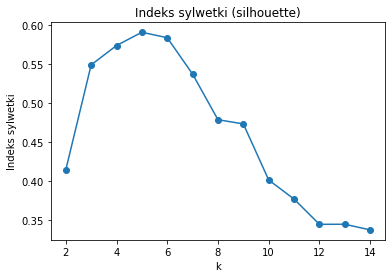

In [126]:
## wybieramy maksymalny indeks sylwetki (k=5)

plt.plot(range(2, 15), sil_score, "-o")

plt.title("Indeks sylwetki (silhouette)")
plt.xlabel("k")
plt.ylabel("Indeks sylwetki")
plt.show()

In [128]:
# arbitralnie wybieramy k=5 (równie dobrze moglibyśmy wybrać k=3 na podstawie WSS)

model_kmeans = KMeans(n_clusters=5, n_init=10, random_state=7)

model_kmeans.fit(Xsmall)
centers_kmeams = model_kmeans.cluster_centers_
labels_kmeans = model_kmeans.labels_

In [129]:
labels_birch.shape, labels_kmeans.shape

((2000,), (161,))

In [130]:
labels_fin = labels_kmeans[labels_birch]
labels_fin.shape

(2000,)

In [131]:
np.bincount(labels_fin)

array([571, 458, 285, 286, 400])

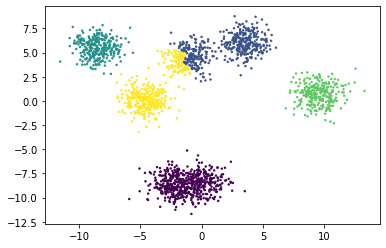

In [132]:
plt.scatter(X[:, 0], X[:, 1], c=labels_fin, s=2)
plt.show()

### Model 2 (podajemy znaną liczbę klastrów)

In [135]:
model_birch2 = Birch(n_clusters=KMeans(n_clusters=5, n_init=10, random_state=7))
model_birch2.fit(X)

np.bincount(model_birch2.labels_)

array([571, 458, 285, 286, 400])

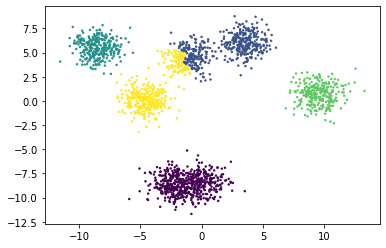

In [136]:
plt.scatter(X[:, 0], X[:, 1], c=model_birch2.labels_, s=2)
plt.show()

### Model 3 (tylko algorytm k-średnich, bez BIRCH)

In [143]:
wss2 = []
sil_score2 = []

for i in range(1, 15):
    
    model_kmeans2 = KMeans(n_clusters=i, n_init=10, random_state=7)
    model_kmeans2.fit(X)
    
    wss2.append(model_kmeans2.inertia_)  # WSS
    
    if i > 1:
        sil_score2.append(silhouette_score(X, model_kmeans2.labels_))  # silhouette

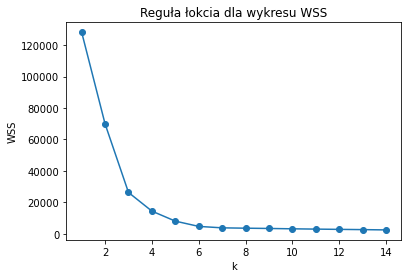

In [144]:
plt.plot(range(1, 15), wss2, "-o")

plt.title("Reguła łokcia dla wykresu WSS")
plt.xlabel("k")
plt.ylabel("WSS")
plt.show()

In [145]:
# automatyczne wyznaczanie punktu przegięcia

kl = KneeLocator(range(1, 15), wss, curve="convex", direction="decreasing")
kl.elbow

4

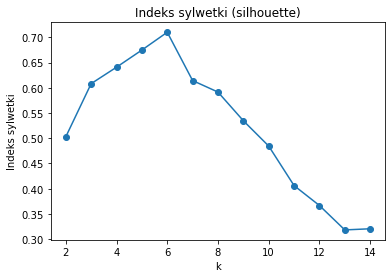

In [147]:
## wybieramy maksymalny indeks sylwetki (k=5)

plt.plot(range(2, 15), sil_score2, "-o")

plt.title("Indeks sylwetki (silhouette)")
plt.xlabel("k")
plt.ylabel("Indeks sylwetki")
plt.show()

In [148]:
# arbitralnie wybieramy k=6 (równie dobrze moglibyśmy wybrać k=4 na podstawie WSS)

model_kmeans2 = KMeans(n_clusters=6, n_init=10, random_state=7)

model_kmeans2.fit(X)

KMeans(n_clusters=6, n_init=10, random_state=7)

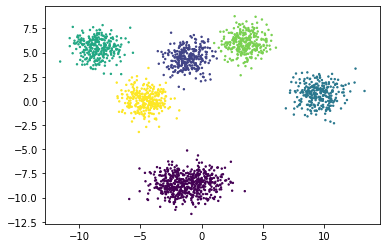

In [149]:
# algorytm k-means lepiej znajduje klastry, bo pracuje dla pełnych danych!

plt.scatter(X[:, 0], X[:, 1], c=model_kmeans2.labels_, s=2)
plt.show()

### Model 4 (BIRCH, `threshold=5`)

In [154]:
# UWAGA: mamy zbyt mało `subclasters`!

model_birch3 = Birch(n_clusters=None, threshold=5)
model_birch3.fit(X)

centers_birch3 = model_birch3.subcluster_centers_
centers_birch3

array([[ 6.55925546,  3.33426455],
       [-4.7270908 ,  3.31289009],
       [-1.21334393, -8.58927799]])

### Model 5 (BIRCH dla pełnych danych, znana liczba klastrów k=7)

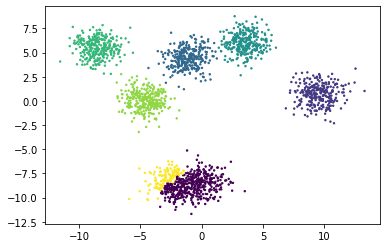

In [155]:
model_birch4 = Birch(n_clusters=7)
model_birch4.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=model_birch4.labels_, s=2)
plt.show()

## Ćwiczenie 3: algorytm BIRCH i grupowanie aglomeracyjne na danych `blobs`

Powtórz analizę dla danych `blobs` dla klasteryzacji aglomeracyjnej. Zastosuj w pierwszym kroku algorytm BIRCH, a następnie klasteryzację aglomeracyjną. Porównaj wyniki z klasteryzacją aglomeracyjną bez wstępnego grupowania za pomocą BIRCH.

### Model 1 (wyliczamy optymalną liczbę klastrów)

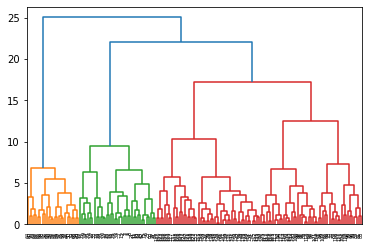

In [165]:
L1 = linkage(Xsmall, method="complete", metric="euclidean")
dendrogram(L1)
plt.show()

In [166]:
clust1 = fcluster(L1, 4, criterion="maxclust")  # na podstawie dendrogramu wybieramy k=4

labels_fin2 = clust1[labels_birch]

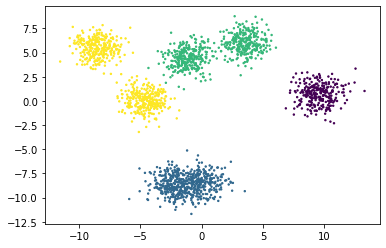

In [167]:
plt.scatter(X[:, 0], X[:, 1], c=labels_fin2, s=2)
plt.show()

**Inny sposób (silhouette)**

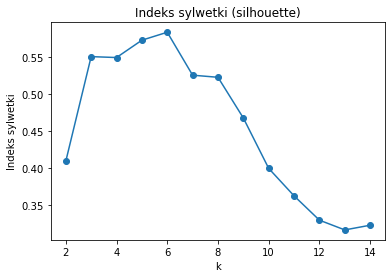

In [179]:
sil_score = []

for i in range(2, 15):
    
    model = AgglomerativeClustering(n_clusters=i, linkage="ward")
    model.fit(Xsmall)
    
    sil_score.append(silhouette_score(Xsmall, model.labels_))  # silhouette
    
plt.plot(range(2, 15), sil_score, "-o")

plt.title("Indeks sylwetki (silhouette)")
plt.xlabel("k")
plt.ylabel("Indeks sylwetki")
plt.show()

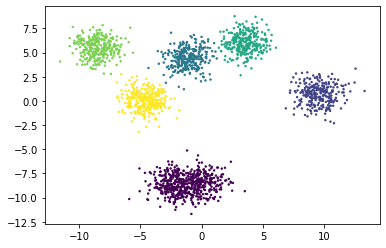

In [180]:
## wybieramy maksymalny indeks sylwetki (k=6)

model_agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
model_agg.fit(Xsmall)

labels_fin = model_agg.labels_[labels_birch]

plt.scatter(X[:, 0], X[:, 1], c=labels_fin, s=2)
plt.show()

### Model 2 (tylko algorytm klasteryzacji hierarchicznej, bez BIRCH)

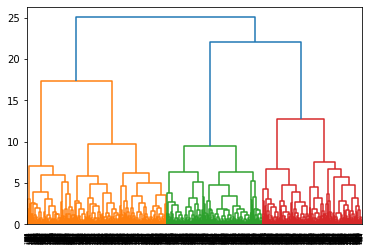

In [168]:
L2 = linkage(X, method="complete", metric="euclidean")
dendrogram(L2)
plt.show()

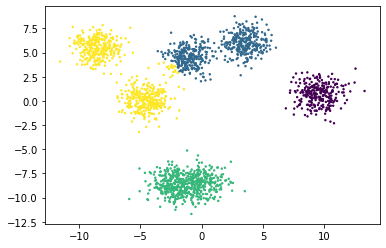

In [170]:
# algorytm na pełnych danych jest mniej dokładny niż z zastosowaniem BIRCH

clust2 = fcluster(L2, 4, criterion="maxclust")  # na podstawie dendrogramu wybieramy k=4

plt.scatter(X[:, 0], X[:, 1], c=clust2, s=2)
plt.show()

**Inny sposób (silhouette)**

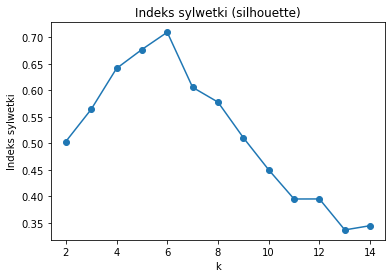

In [181]:
sil_score = []

for i in range(2, 15):
    
    model = AgglomerativeClustering(n_clusters=i, linkage="ward")
    model.fit(X)
    
    sil_score.append(silhouette_score(X, model.labels_))  # silhouette
    
plt.plot(range(2, 15), sil_score, "-o")

plt.title("Indeks sylwetki (silhouette)")
plt.xlabel("k")
plt.ylabel("Indeks sylwetki")
plt.show()

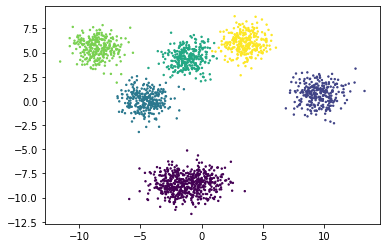

In [184]:
## wybieramy maksymalny indeks sylwetki (k=6)

model_agg = AgglomerativeClustering(n_clusters=6, linkage="ward")
model_agg.fit(X)

plt.scatter(X[:, 0], X[:, 1], c=model_agg.labels_, s=2)
plt.show()

# Grupowanie Mini-Batch K-Means

## Przykład 4: porównanie algorytmów K-Means i Mini-Batch K-Means na danych `blobs`

Dla danych `blobs` (jak wyżej) porównaj działanie algorytmów K-Means i Mini-Batch K-Means dla liczby klastrów `k=7`: 
oblicz czasy działania algorytmów i WSS znalezionych grupowań. Dla jakiej części obserwacji algorytmy 
przyporządkowały je do różnych klastrów?
    
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html

In [185]:
X = make_blobs(n_samples=2000, centers=7, random_state=7)[0]

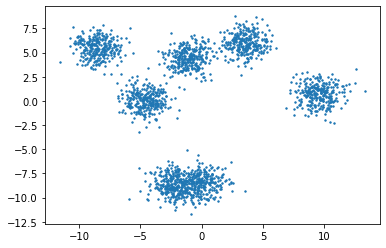

In [186]:
plt.scatter(X[:, 0], X[:, 1], s=2)
plt.show()

In [191]:
# KMeans

kmeans = KMeans(n_clusters=7, n_init=10, random_state=13)

t0 = time.time()
kmeans.fit(X)
t_kmeans = time.time() - t0

wyniki = pd.DataFrame(columns=["KMeans", "Mini-Batch KMeans"],
                      index=["czas", "WSS"])

wyniki["KMeans"] = [t_kmeans, kmeans.inertia_]

In [192]:
# Mini-Batch KMeans

batch_size = 200  # nie jest to wartość zalecana, ale zbiór danych jest mały

mbk = MiniBatchKMeans(n_clusters=7, n_init=10, batch_size=batch_size, random_state=13)

t0 = time.time()
mbk.fit(X)
t_mbk = time.time() - t0

wyniki["Mini-Batch KMeans"] = [t_mbk, mbk.inertia_]

In [195]:
round(wyniki, 3)  # KMeans ma trochę lepsze klastrowanie (lepiej zminimalizowany WSS), ale kosztem czasu działania

,KMeans,Mini-Batch KMeans
czas,0.098,0.067
WSS,3712.746,3724.815


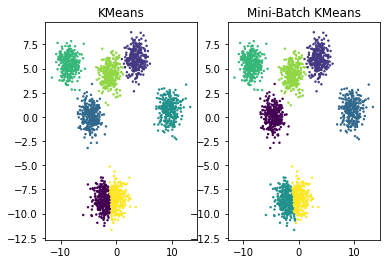

In [198]:
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=kmeans.labels_, s=2)
plt.title("KMeans")

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=mbk.labels_, s=2)
plt.title("Mini-Batch KMeans")

plt.show()

In [200]:
pd.crosstab(kmeans.labels_, mbk.labels_)  # różnica TYLKO w 0.5% obserwacji (11/2000)

col_0,0,1,2,3,4,5,6
row_0,,,,,,,
0,0,0,0,302,0,0,0
1,0,280,0,0,0,0,0
2,286,0,0,0,0,0,0
3,0,0,286,0,0,0,0
4,0,0,0,0,286,0,0
5,0,0,0,0,0,291,0
6,0,0,0,11,0,0,258


## Ćwiczenie 4: porównanie algorytmów BIRCH, K-Means i Mini-Batch K-Means

Dla danych `blobs` z 100 000 obserwacji  porównaj działanie algorytmów BIRCH, KMeans i Mini-Batch K-Means dla liczby 
klastrów `k=100`: oblicz czasy działania algorytmów i ARI znalezionych grupowań. Dla algorytmu BIRCH wypróbuj dwie 
metody grupowania w drugim kroku: aglomeracyjne z metodą Warda oraz k-średnich.

In [201]:
X, labels = make_blobs(100000, centers=100, center_box=[0, 100], random_state=7)

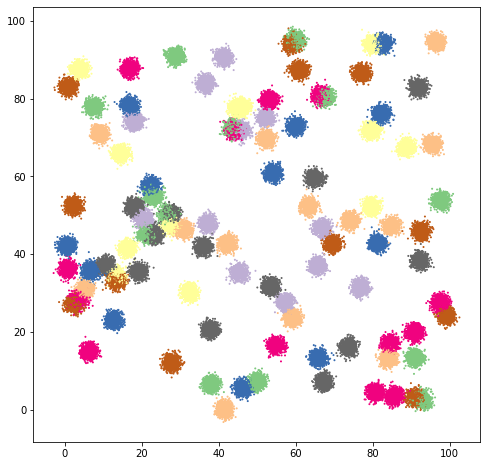

In [217]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], s=1, c=labels, cmap="Accent")
plt.show()

In [248]:
# podsumowanie wszystkich modeli

batch_size = 256 * cpu_count()  # dobierany na podstawie liczby rdzeni/wątków procesora

model_names=["KMeans", "Mini-Batch KMeans", "BIRCH_Agg", "BIRCH_KMeans"]

wyniki = pd.DataFrame(columns=model_names, index=["czas", "ARI"])

models = [KMeans(n_clusters=100, n_init=10, random_state=13),
          MiniBatchKMeans(n_clusters=100, n_init=10, batch_size=batch_size, random_state=13),
          Birch(n_clusters=AgglomerativeClustering(n_clusters=100, linkage="ward")),
          Birch(n_clusters=KMeans(n_clusters=100, n_init=10, random_state=13))]

for model_name, model in zip(model_names, models):

    t_start = time.time()
    model.fit(X)
    t_stop = time.time() - t_start
    
    wyniki[model_name] = [t_stop, adjusted_rand_score(model.labels_, labels)]
    
wyniki

,KMeans,Mini-Batch KMeans,BIRCH_Agg,BIRCH_KMeans
czas,8.315378,1.088971,4.361434,4.495184
ARI,0.866349,0.872975,0.846267,0.854986


# Ćwiczenie poznanych metod: zbiór danych `digits`

Pogrupuj dane: https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

In [533]:
digits = load_digits()

X = digits.data
y = digits.target

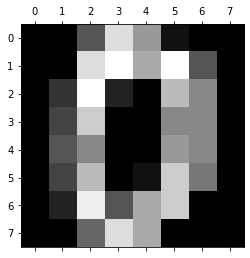

In [534]:
plt.matshow(digits.images[0], cmap='gray')
plt.show()

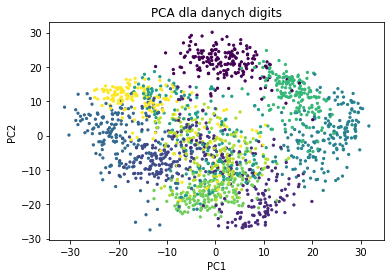

In [535]:
#X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:,0], X_pca[:,1], c=y, s=5)
plt.title("PCA dla danych digits")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

### Model1: KMeans

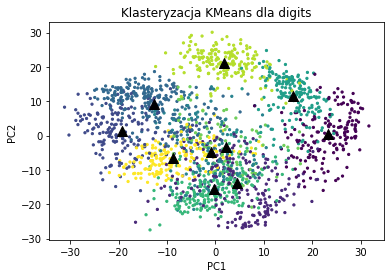

ARI: 0.67
V-measure: 0.74
silhouette: 0.18


In [538]:
model1 = KMeans(n_clusters=10, n_init=10, random_state=7).fit(X)
centers1 = pca.transform(model1.cluster_centers_)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=model1.labels_, s=5)
plt.scatter(centers1[:, 0], centers1[:, 1], marker="^", c="black", s=100)

plt.title("Klasteryzacja KMeans dla digits")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print(f"ARI: {round(adjusted_rand_score(model1.labels_, y), 2)}")
print(f"V-measure: {round(v_measure_score(model1.labels_, y), 2)}")
print(f"silhouette: {round(silhouette_score(X, model1.labels_), 2)}")

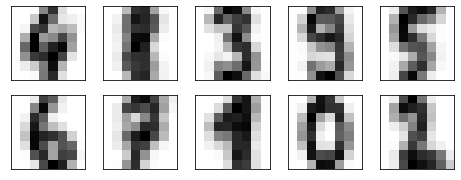

In [493]:
# tak wyglądają punkty odpowiadające środkom klastrów

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = model1.cluster_centers_.reshape(10, 8, 8) 

for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap = plt.cm.binary) 

In [496]:
pd.crosstab(model1.labels_, y)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,1,0,0,0,164,2,0,0,0,0
1,0,99,8,7,3,0,2,2,102,2
2,0,1,13,154,0,0,0,0,2,6
3,0,0,2,13,0,43,0,0,51,139
4,0,1,0,2,0,136,0,1,4,6
5,0,2,0,0,0,1,177,0,2,0
6,0,0,3,7,9,0,0,174,5,7
7,0,55,2,0,5,0,1,2,5,20
8,177,0,1,0,0,0,1,0,0,0


### Model2: AgglomerativeClustering

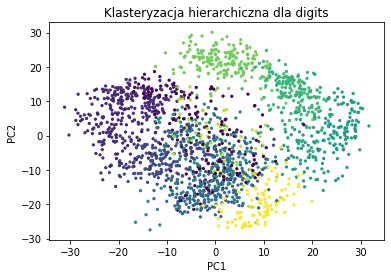

ARI: 0.79
V-measure: 0.87
silhouette: 0.18


In [471]:
model2 = AgglomerativeClustering(n_clusters=10, linkage="ward").fit(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=model2.labels_, s=5)

plt.title("Klasteryzacja hierarchiczna dla digits")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print(f"ARI: {round(adjusted_rand_score(model2.labels_, y), 2)}")
print(f"V-measure: {round(v_measure_score(model2.labels_, y), 2)}")
print(f"silhouette: {round(silhouette_score(X, model2.labels_), 2)}")

In [497]:
pd.crosstab(model2.labels_, y)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,0,0,0,0,0,179,0,0,0,2
1,0,0,0,169,0,2,0,0,1,145
2,0,27,166,0,0,0,0,0,4,0
3,0,0,1,1,3,0,0,179,1,11
4,0,0,10,13,0,0,1,0,165,2
5,0,0,0,0,178,0,0,0,0,0
6,0,0,0,0,0,1,180,0,0,0
7,178,0,0,0,0,0,0,0,0,0
8,0,59,0,0,0,0,0,0,1,20


### Model3: DBSCAN

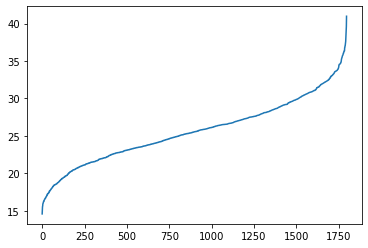

In [402]:
min_samples = 20

model_knn = NearestNeighbors(n_neighbors=min_samples).fit(X)

distances = model_knn.kneighbors(X)[0]
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.show()

In [444]:
kl = KneeLocator(range(0, len(distances)), distances,
                 curve="concave", direction="increasing", interp_method="polynomial")

eps = distances[kl.elbow]
print(f"distance[{kl.elbow}] = {round(eps, 2)}")  # w rzeczywistości właściwa wartość jest trochę inna ...

distance[189] = 20.49


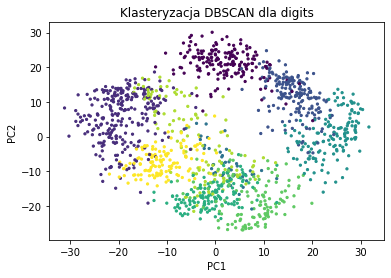

ARI: 0.51
V-measure: 0.73
silhouette: 0.14


In [472]:
model3 = DBSCAN(eps=24, min_samples=min_samples).fit(X)

plt.scatter(X_pca[model3.labels_ > -1, 0], X_pca[model3.labels_ > -1, 1], c=model3.labels_[model3.labels_ > -1], s=5)
        
plt.title("Klasteryzacja DBSCAN dla digits")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.show()

print(f"ARI: {round(adjusted_rand_score(model3.labels_, y), 2)}")
print(f"V-measure: {round(v_measure_score(model3.labels_, y), 2)}")
print(f"silhouette: {round(silhouette_score(X, model3.labels_), 2)}")

In [469]:
np.unique(model3.labels_)  # model nie znajduje wszystkich cyfr, stąd niższa wartość ARI oraz V-measure

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8])

In [498]:
pd.crosstab(model3.labels_, y)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
-1,1,45,44,34,37,56,5,38,143,64
0,177,0,0,0,0,0,0,0,0,0
1,0,0,0,149,0,4,0,0,1,114
2,0,0,0,0,0,1,176,0,0,0
3,0,42,0,0,0,0,0,0,0,1
4,0,0,0,0,144,0,0,0,0,0
5,0,0,0,0,0,0,0,141,0,0
6,0,95,0,0,0,0,0,0,30,0
7,0,0,0,0,0,121,0,0,0,1


### Model4: Mini-Batch KMeans

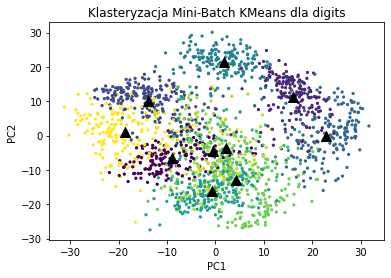

ARI: 0.67
V-measure: 0.74
silhouette: 0.18


In [490]:
batch_size = 150

model4 = MiniBatchKMeans(n_clusters=10, n_init=10, batch_size=batch_size, random_state=7).fit(X)
centers4 = pca.transform(model4.cluster_centers_)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=model4.labels_, s=5)
plt.scatter(centers4[:, 0], centers4[:, 1], marker="^", c="black", s=100)

plt.title("Klasteryzacja Mini-Batch KMeans dla digits")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print(f"ARI: {round(adjusted_rand_score(model4.labels_, y), 2)}")
print(f"V-measure: {round(v_measure_score(model4.labels_, y), 2)}")
print(f"silhouette: {round(silhouette_score(X, model4.labels_), 2)}")

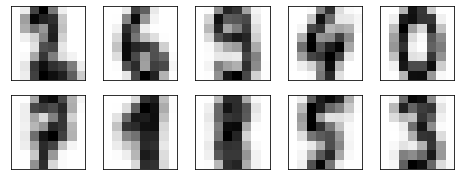

In [501]:
# tak wyglądają punkty odpowiadające środkom klastrów

fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = model4.cluster_centers_.reshape(10, 8, 8) 

for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap = plt.cm.binary) 

In [499]:
pd.crosstab(model4.labels_, y)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,0,23,147,0,0,0,0,0,3,0
1,0,3,0,0,0,1,177,0,2,0
2,0,0,1,10,0,40,0,0,35,141
3,1,0,0,0,164,2,0,1,0,0
4,176,0,1,0,0,0,1,0,1,0
5,0,0,3,6,8,0,0,167,3,7
6,0,56,4,0,5,0,1,2,7,20
7,0,98,7,7,3,0,2,2,111,1
8,1,1,0,1,1,137,0,7,8,7


### Model5: BIRCH

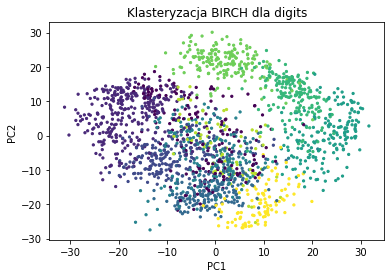

ARI: 0.79
V-measure: 0.87
silhouette: 0.18


In [509]:
model5 = Birch(n_clusters=10).fit(X)
#model5 = Birch(n_clusters=KMeans(n_clusters=10, n_init=10, random_state=7)).fit(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=model5.labels_, s=5)

plt.title("Klasteryzacja BIRCH dla digits")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

print(f"ARI: {round(adjusted_rand_score(model5.labels_, y), 2)}")
print(f"V-measure: {round(v_measure_score(model5.labels_, y), 2)}")
print(f"silhouette: {round(silhouette_score(X, model5.labels_), 2)}")

In [507]:
pd.crosstab(model5.labels_, y)

col_0,0,1,2,3,4,5,6,7,8,9
row_0,,,,,,,,,,
0,0,0,0,0,0,179,0,0,0,2
1,0,0,0,169,0,2,0,0,1,145
2,0,27,166,0,0,0,0,0,4,0
3,0,0,1,1,3,0,0,179,1,11
4,0,0,10,13,0,0,1,0,165,2
5,0,0,0,0,178,0,0,0,0,0
6,0,0,0,0,0,1,180,0,0,0
7,178,0,0,0,0,0,0,0,0,0
8,0,59,0,0,0,0,0,0,1,20


# Źródła:

Hastie, Trevor, et al. The elements of statistical learning: data mining, inference, and prediction. Ed. 2. New York: springer, 2009.

Muller, Andreas, et al. Machine learning, Python i data science, Wprowadzenie. Helion, 2021.

https://en.wikipedia.org/wiki/Rand_index

https://www.geeksforgeeks.org/ml-v-measure-for-evaluating-clustering-performance/

https://medium.com/analytics-vidhya/the-ultimate-guide-for-clustering-mixed-data-1eefa0b4743b

https://www.coryjmaklin.com/2019-07-01_Machine-Learning--BIRCH-Clustering-Algorithm-Clearly-Explained-fb9838cbeed9/

https://www.geeksforgeeks.org/ml-mini-batch-k-means-clustering-algorithm/

https://www.kaggle.com/code/ksavleen/handwritten-digit-recognition-kmeans-clustering/notebook

